In [2]:
from pandas import Series,DataFrame
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl
import math

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


def compute_net_basic(path, name, days):
    df = pd.read_csv(path)
    df = df.tail(days)
    total = len(df)
    year = total / 250
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,3))

    bin = np.arange(0,10,0.2)
    cut = pd.cut(df['pcnt_1d'], bins=bin, labels=bin[:-1], right=False)
    counts = pd.value_counts(cut,sort=False)
    sum_counts = (total - counts.cumsum().to_frame()) / total

    sum_counts.plot(title=name + ' 网格频率（单位：频率）共' + str(days) + '天', ax=axes[0])
    axes[0].grid()

    ii = list(sum_counts.index)
    sum_counts['index'] = ii
    earn = sum_counts['pcnt_1d'] * sum_counts['index'] * sum_counts['index']
    earn = earn.to_frame()
    earn.columns = ['earn']

    year_earn_rate = earn['earn'] * total / 200 / year # 年化收益
    year_earn_rate = year_earn_rate.to_frame()
    year_earn_rate.columns = ['earn_rate']
    year_earn_rate.plot(title=name + ' 年化利润率（单位 %）', ax=axes[1]) 
    axes[1].grid()

    plt.show()

def compute_net_basic_long(path, stock_name, days=10000):
    # 长线指标 1d, 10d, 20d, 60d, 120d, 240d
    peried = [1,5,10,20,60,120,240]
    df = pd.read_csv(path)
    df = df.tail(days)
    total = len(df)
    year = total / 250.0

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    bin = np.arange(0,53,0.2)
    sum_counts = DataFrame()
    year_earn = DataFrame()
    for p in peried:
        p_name = 'pcnt_' + str(p) + 'd'
        cut = pd.cut(df[p_name], bins=bin, labels=bin[:-1], right=False)
        counts = pd.value_counts(cut,sort=False)
        sum_counts[p_name] = (total - counts.cumsum().to_frame()) / total

        #计算整体上下界
        min = df['low'].min()
        max = df['high'].max()
        rate = DataFrame()
        rate['rate'] = list(sum_counts.index)
        rate.index = sum_counts.index
        rate['buy_time'] = (math.log(max/min) / np.log(1+rate['rate']/100)) // 1
        rate['buy_money'] = 1 / rate['buy_time']
        
        earn = sum_counts[p_name] * rate['buy_money'] * rate['rate']
        long_total = total // p
        year_earn[p_name] = earn * long_total / 2 / year # 年化收益
        # year_earn[p_name] = year_earn[p_name] * (rate['buy_time'] * 0.5 // 1) # 根据总购买次数增大对敲网格次数，


    sum_counts.plot(title=stock_name + ' 网格频率（单位：频率）共' + str(year) + '年', ax=axes[0])
    axes[0].grid()
    year_earn.plot(title=stock_name + ' 年化利润率（单位 %）最低 ' + str(min) + ' 最高 ' + str(max), ax=axes[1]) 
    axes[1].grid()



In [3]:
def compute_constant_net_risk(init_money, extra_money, current_price, buy_stock=0, buy_money=0):
    # 计算网格风险值：市值稳定网格法的情况下
    # 画一张图出来，根据网格的变化，求最大回撤，和网格范围
    steps = np.arange(0.1,8,0.1)
    df = DataFrame()
    for s in steps:
        price = current_price
        stock = init_money // (current_price * 100)
        left_money = extra_money
     
        if buy_stock == 0:
            once_money = buy_money
        else:
            once_money = buy_stock * price
     
        while left_money >= once_money and price > 0.01:
            price = price * (1 - s / 100)
            if buy_stock == 0:
                once_money = buy_money
            else:
                once_money = buy_stock * price
     
            if buy_stock == 0:
                stock += buy_money // (price * 100)
                left_money -= buy_money // (price * 100) * (price * 100)
            else:
                stock += buy_stock / 100
                left_money -= buy_stock * price
        
        back_rate = (stock*100*price + left_money) / (init_money + extra_money) * 100
        df[s] = [price, back_rate, stock*100*price]
     
    df = df.T
    df.columns = ['last_price', 'back', 'last_value']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,3))
    df['last_price'].plot(title='最低价格', ax=axes[0])
    axes[0].grid()
    df['back'].plot(title='最低价格时总回撤', ax=axes[1])
    axes[1].grid()
    df['last_value'].plot(title='最低价格时总市值', ax=axes[2])
    axes[2].grid()

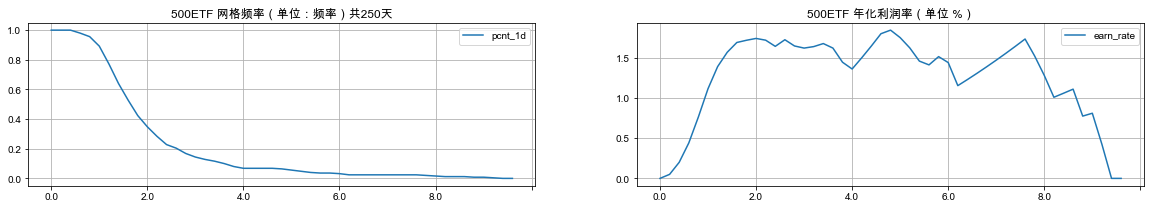

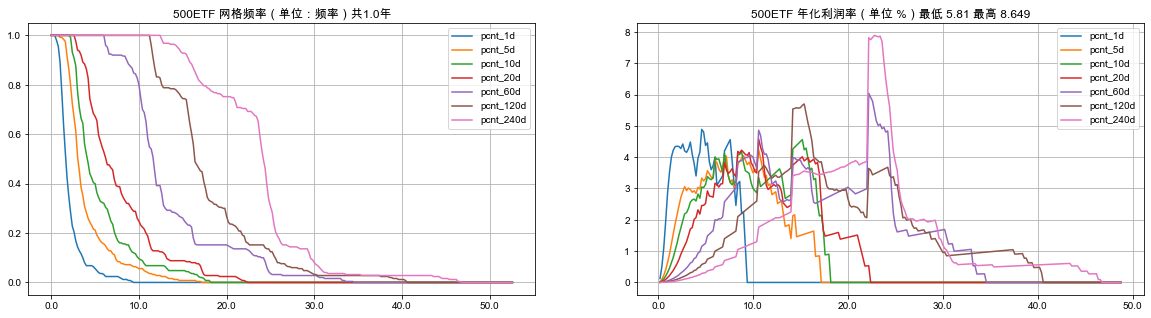

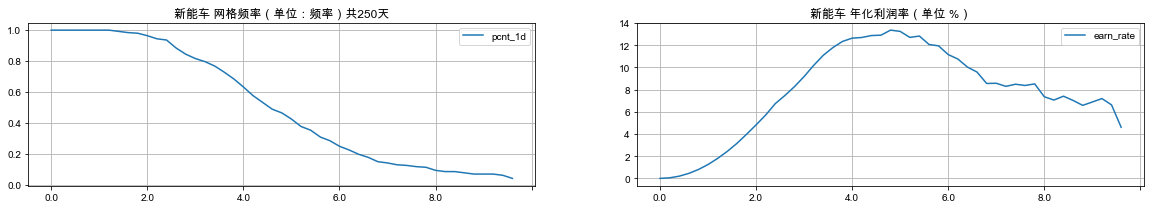

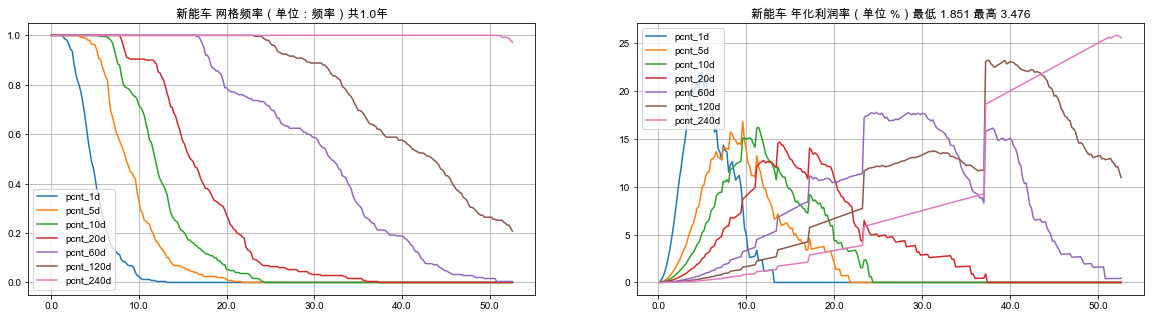

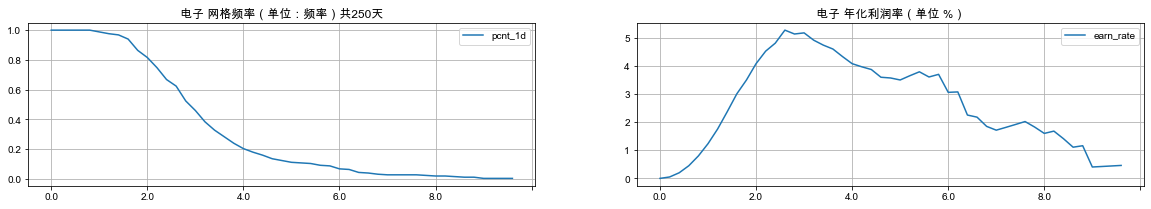

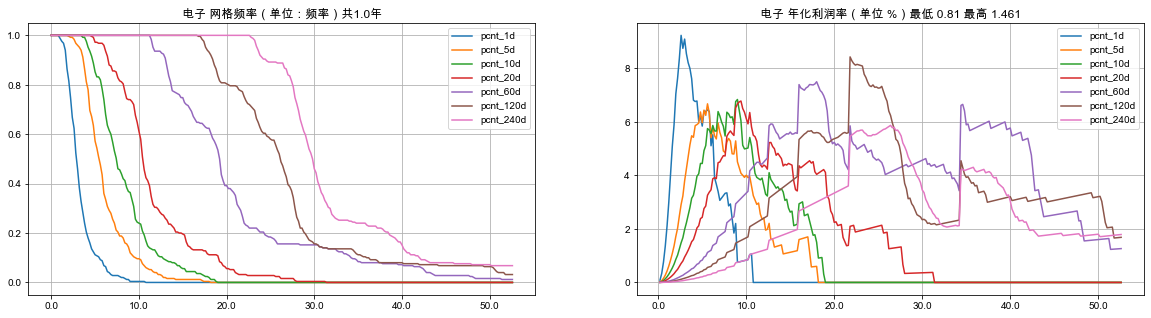

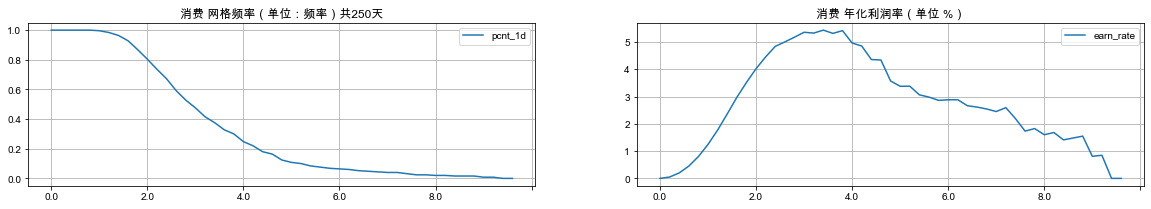

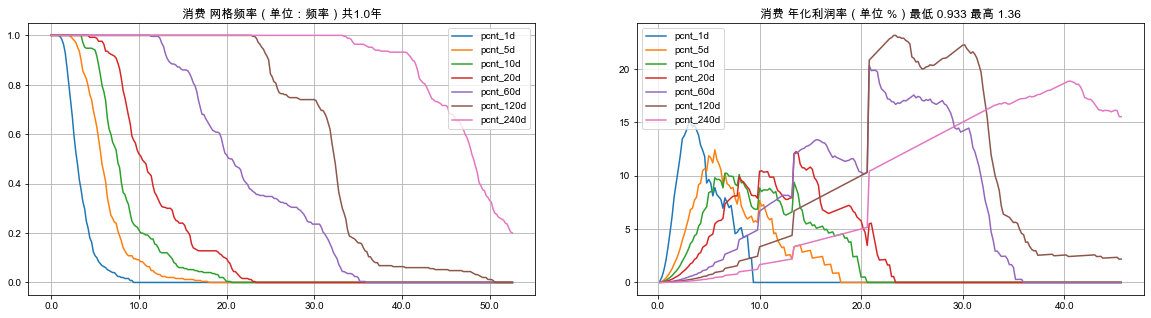

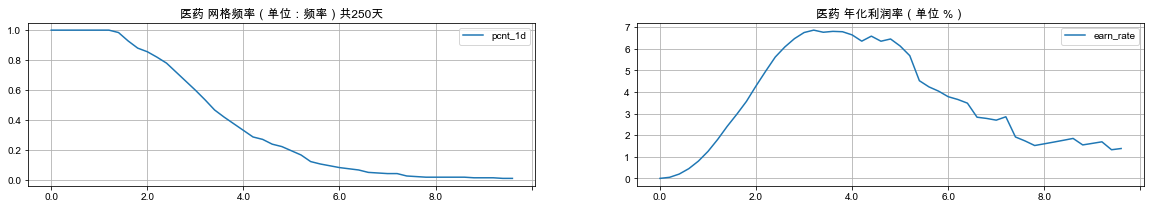

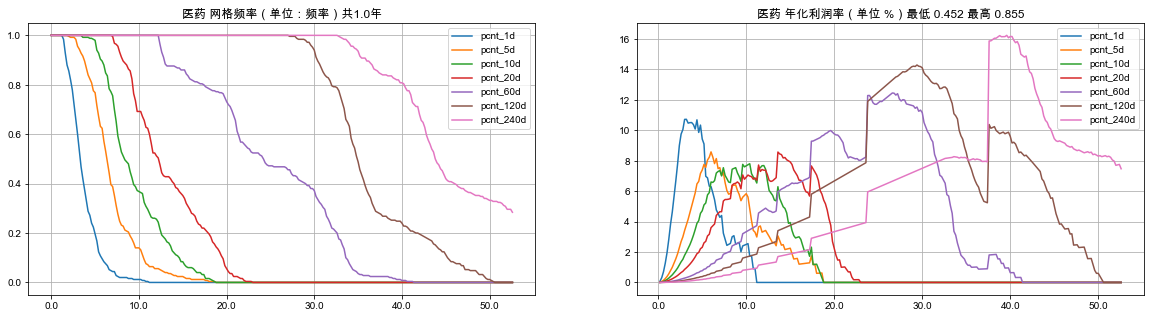

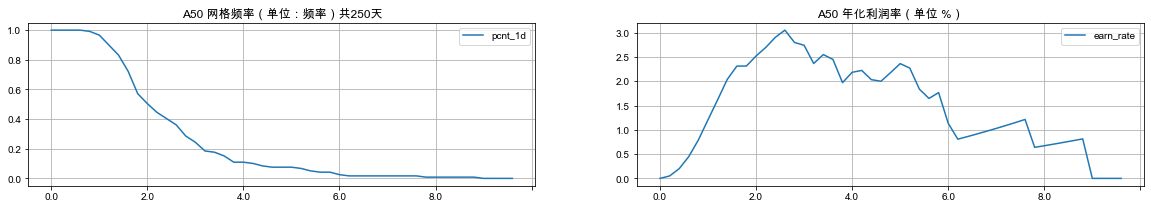

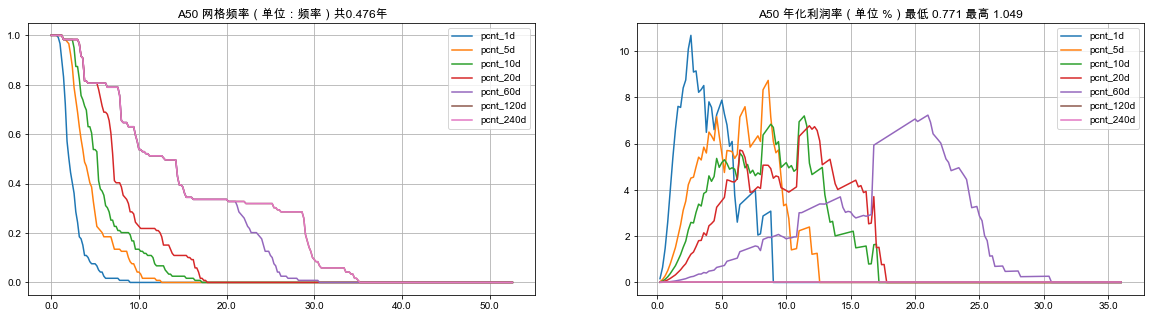

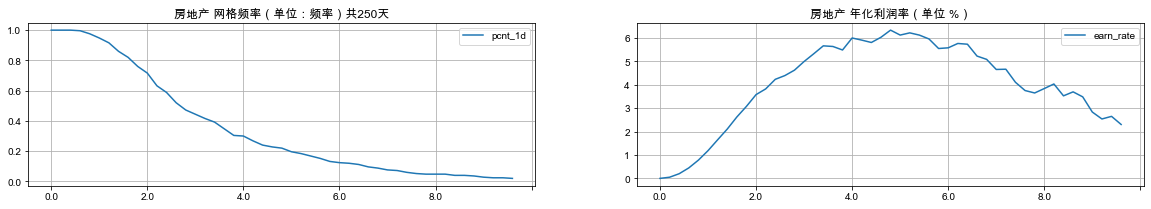

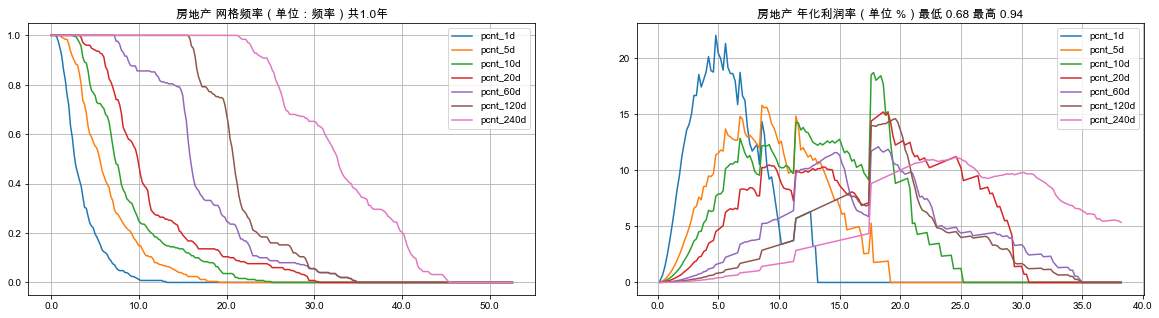

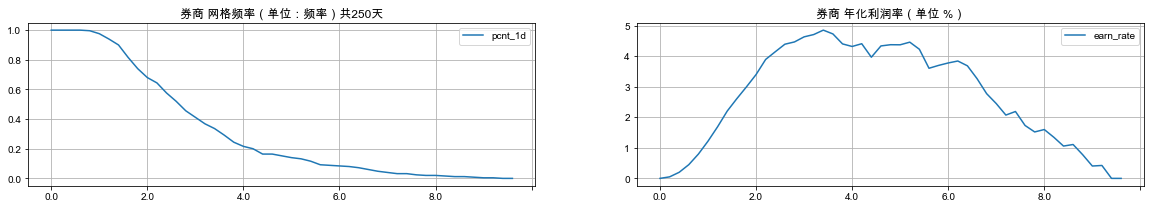

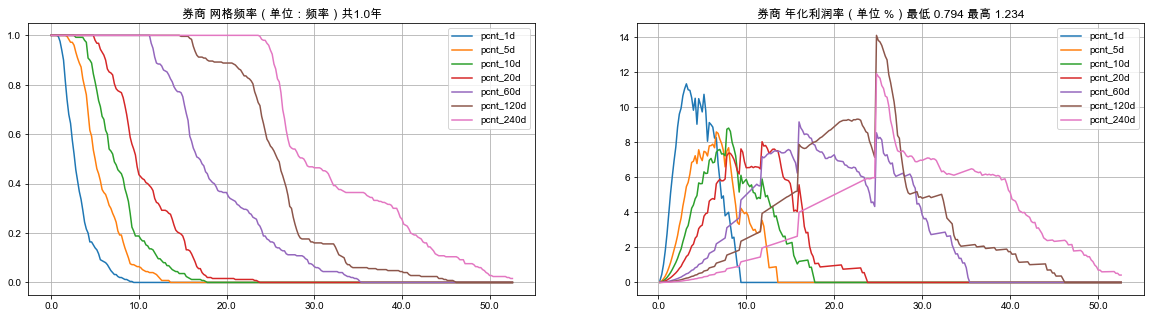

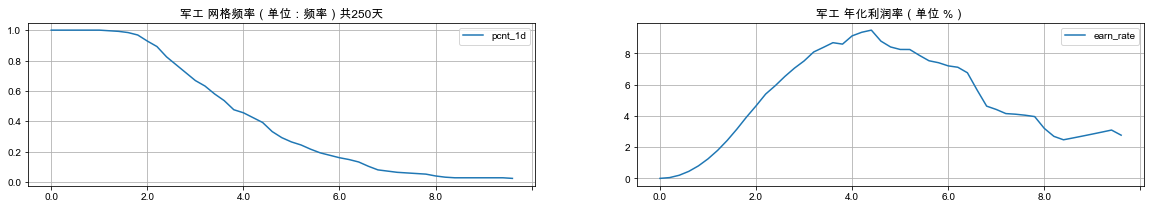

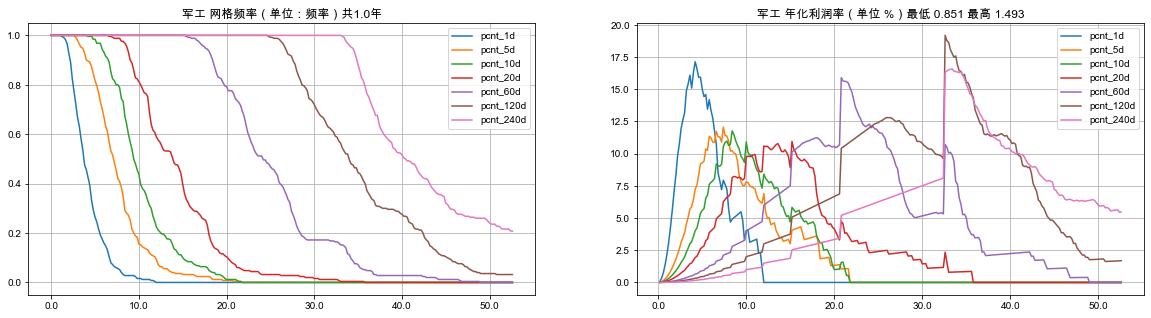

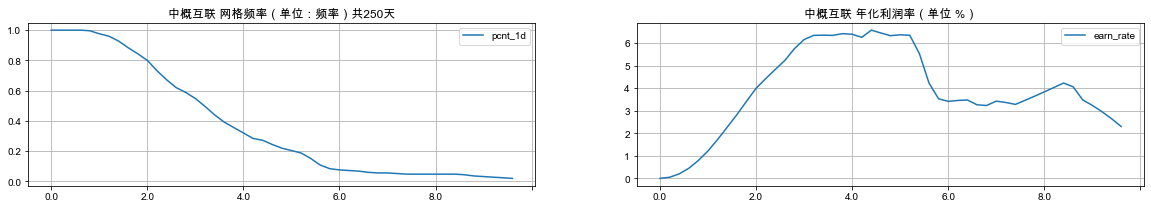

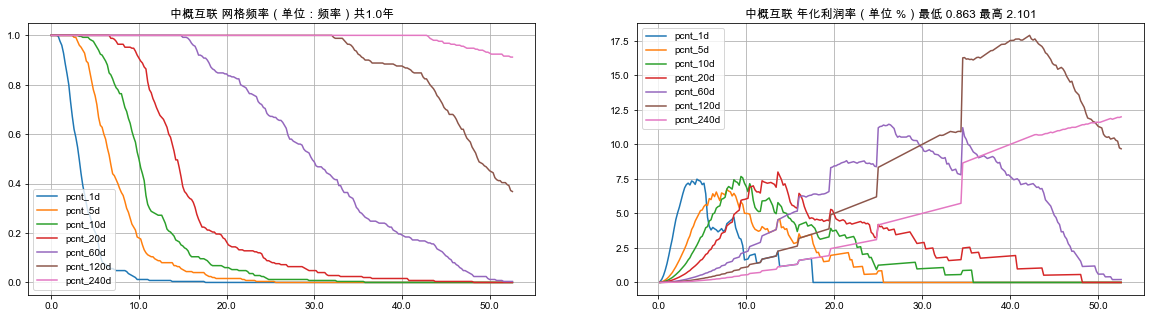

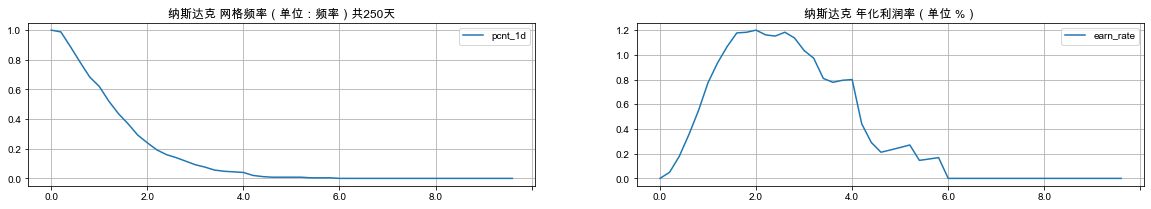

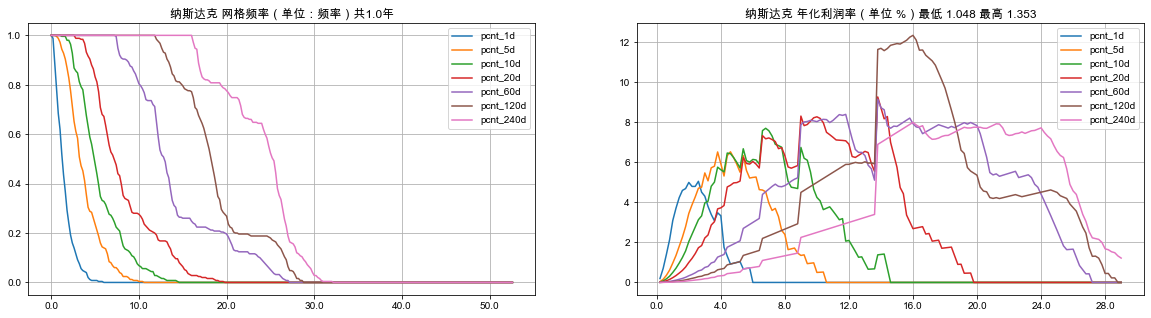

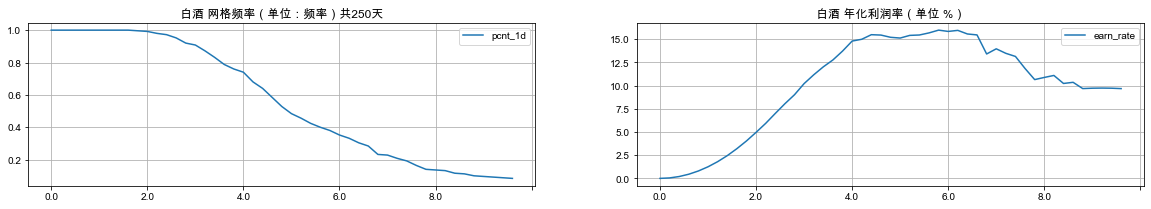

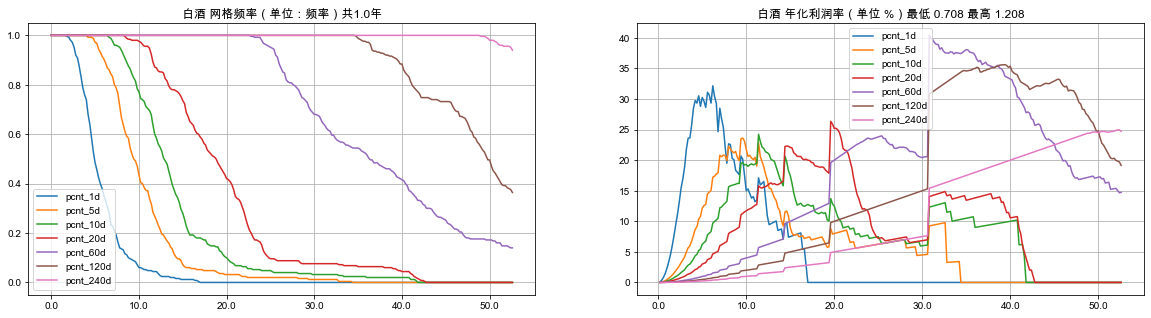

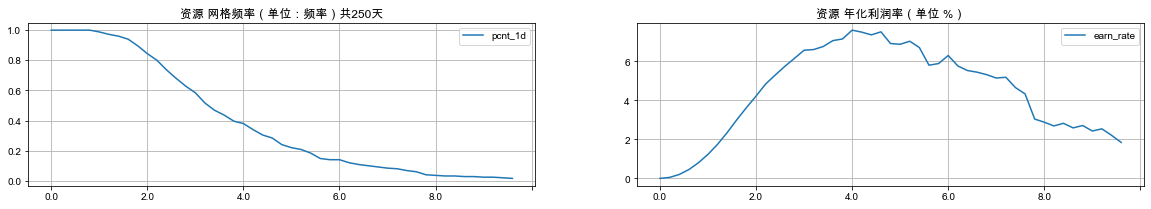

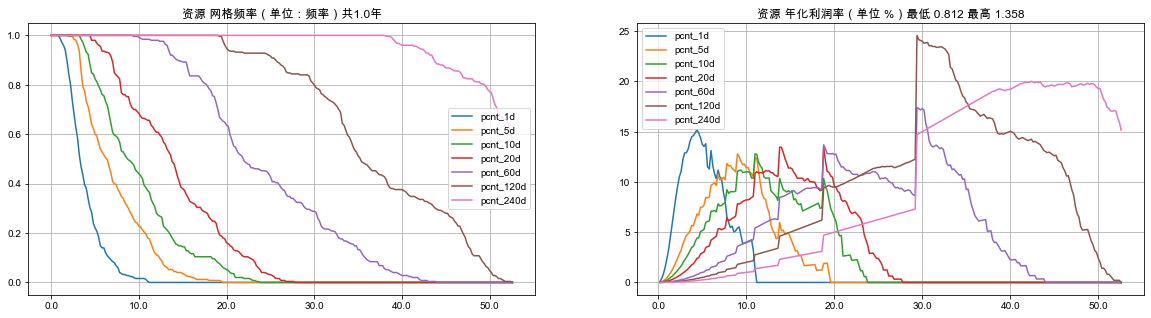

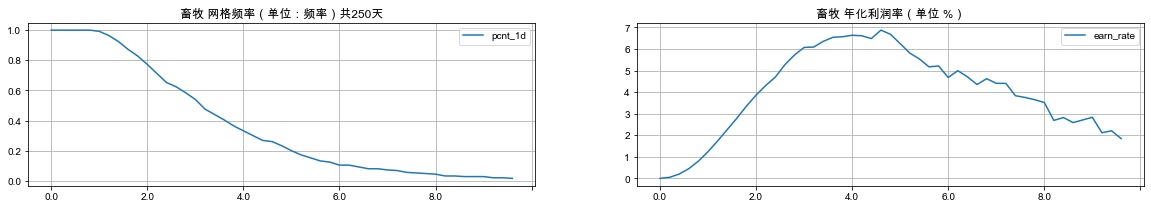

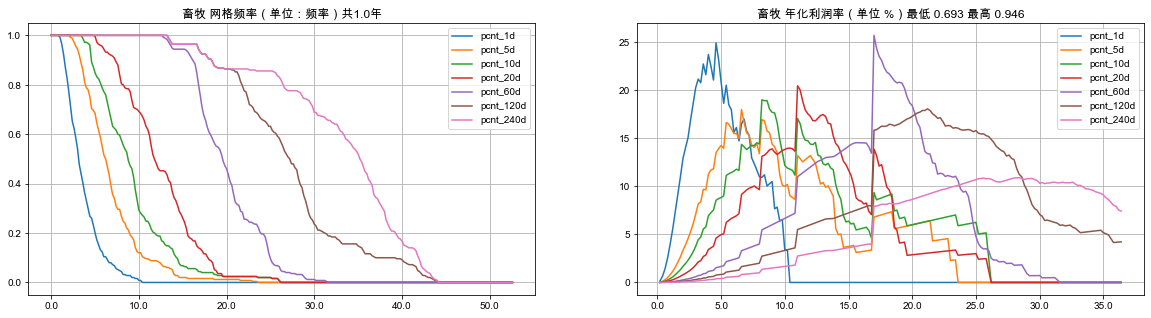

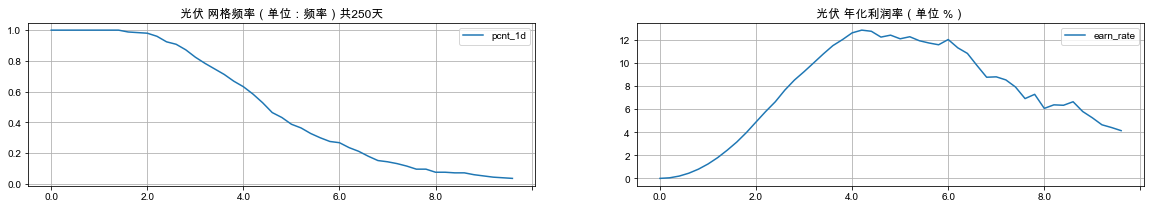

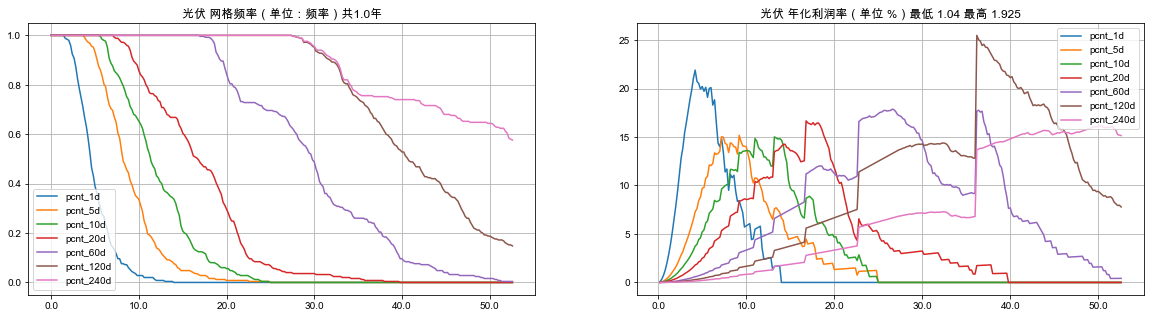

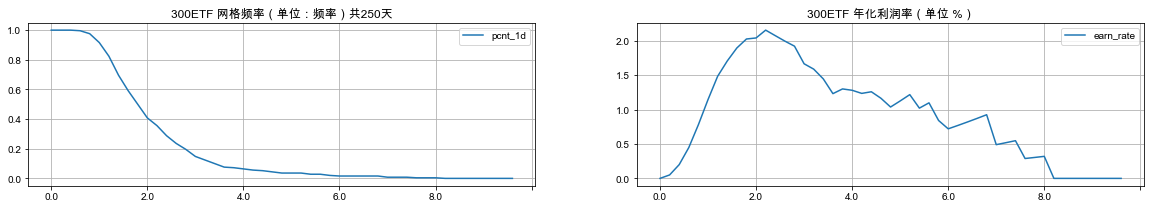

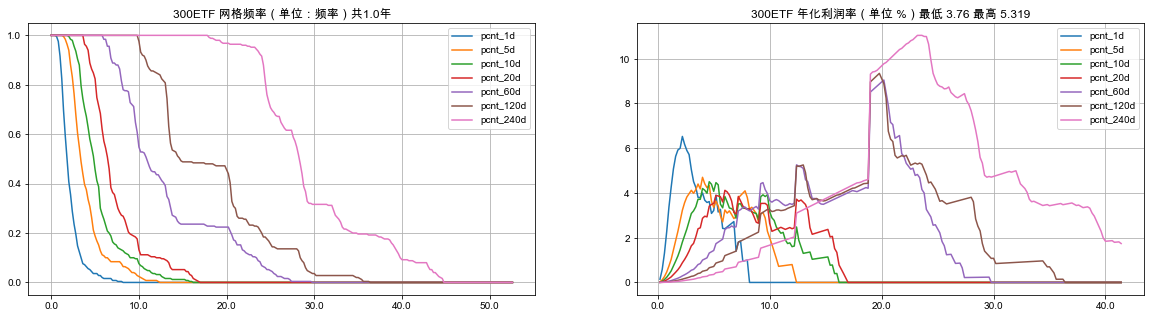

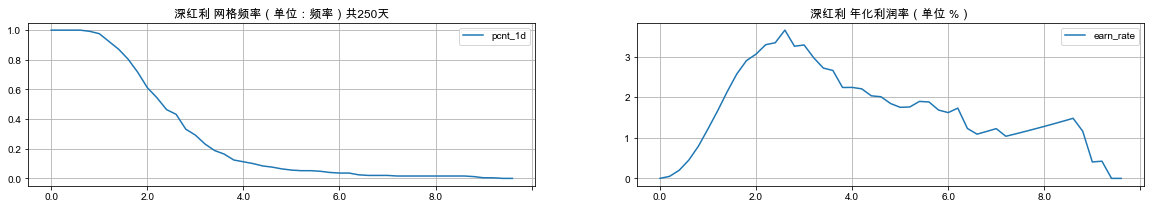

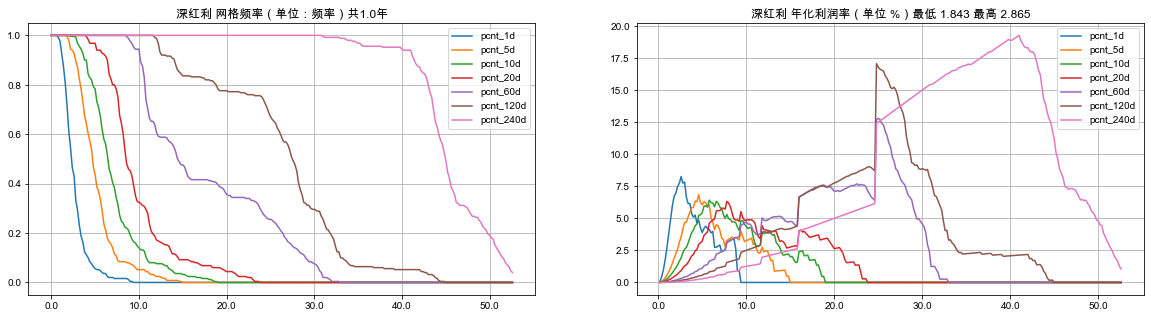

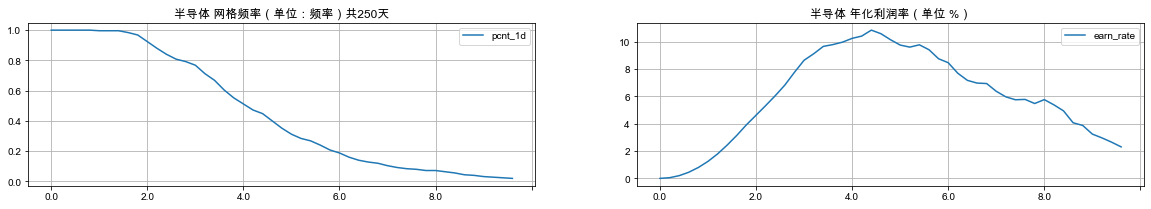

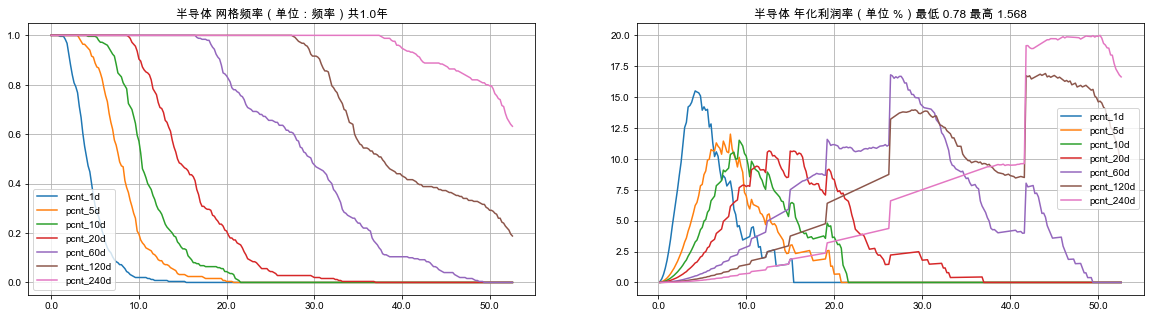

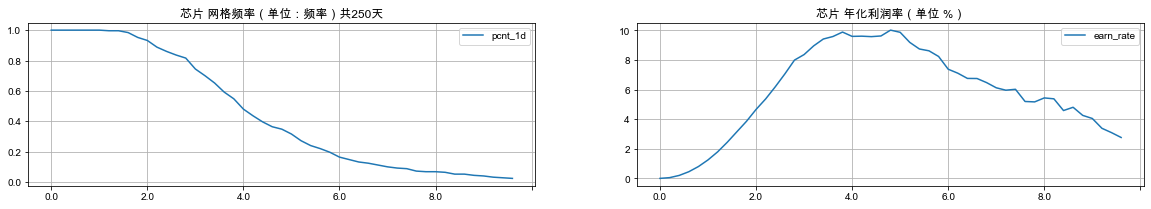

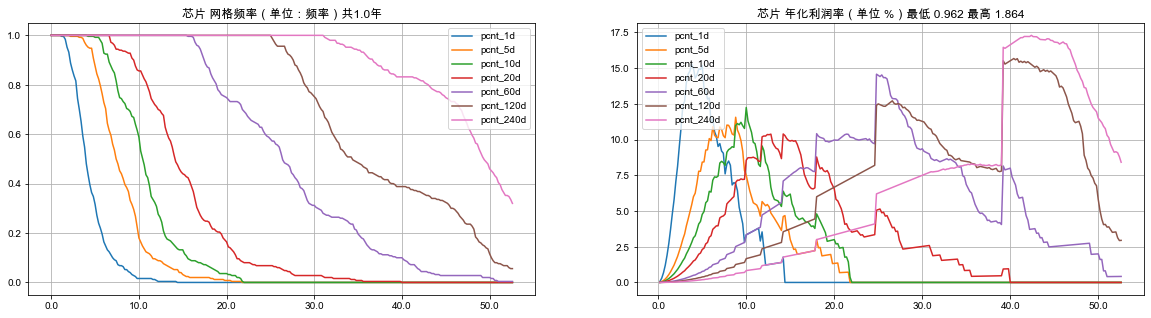

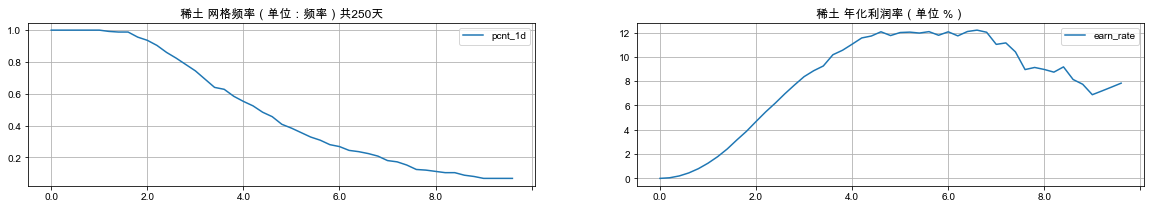

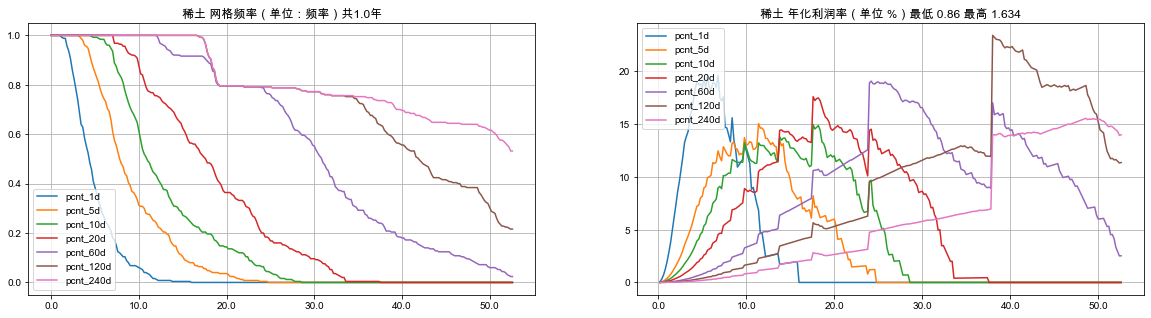

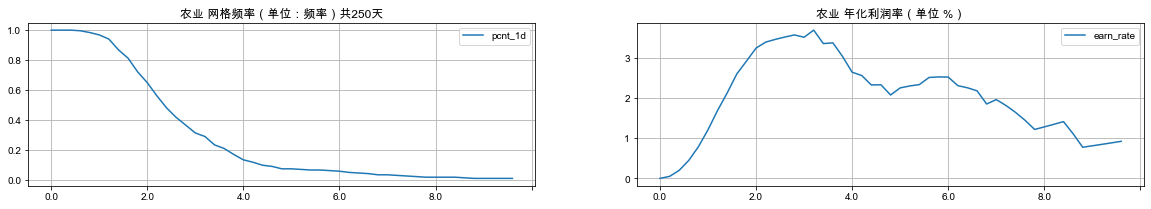

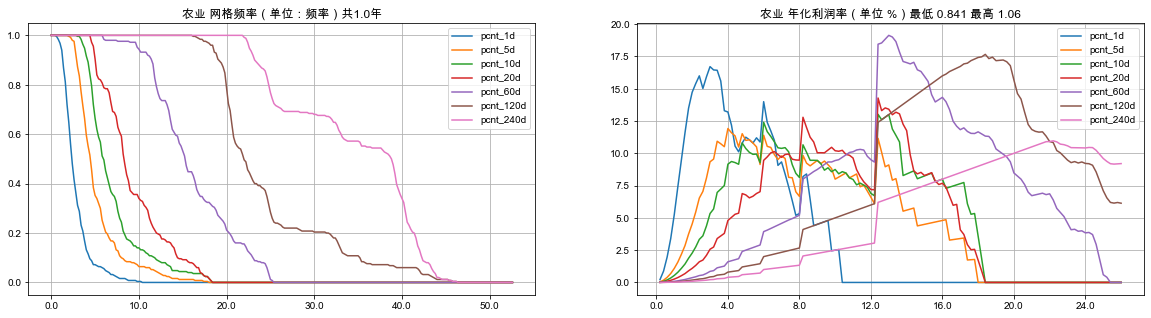

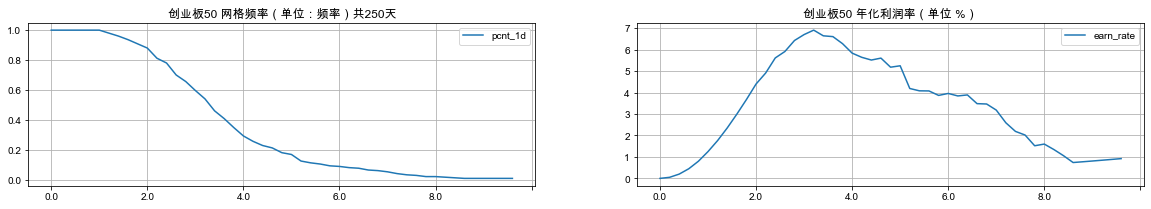

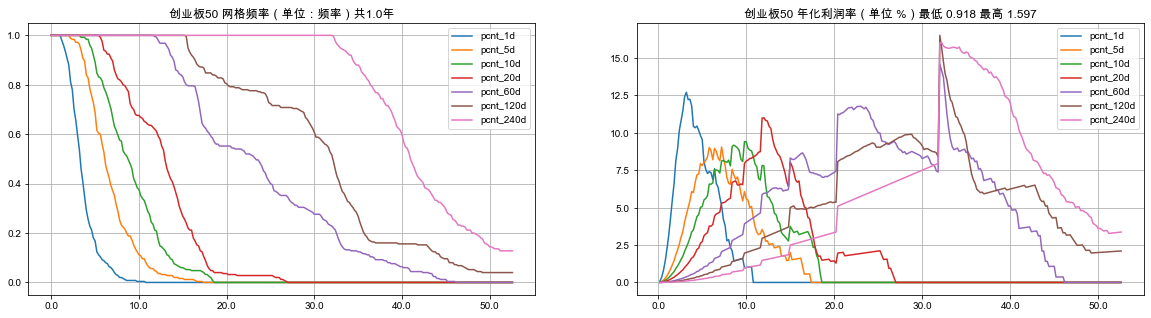

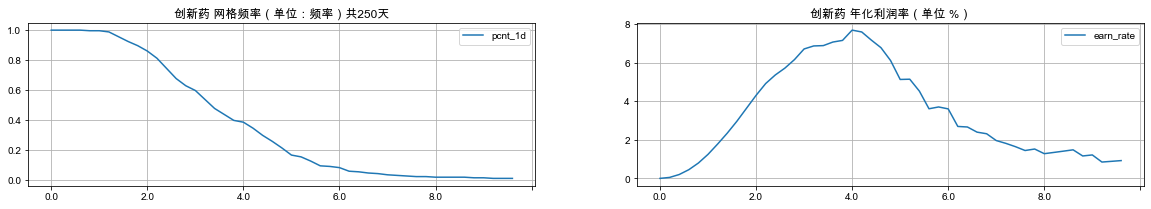

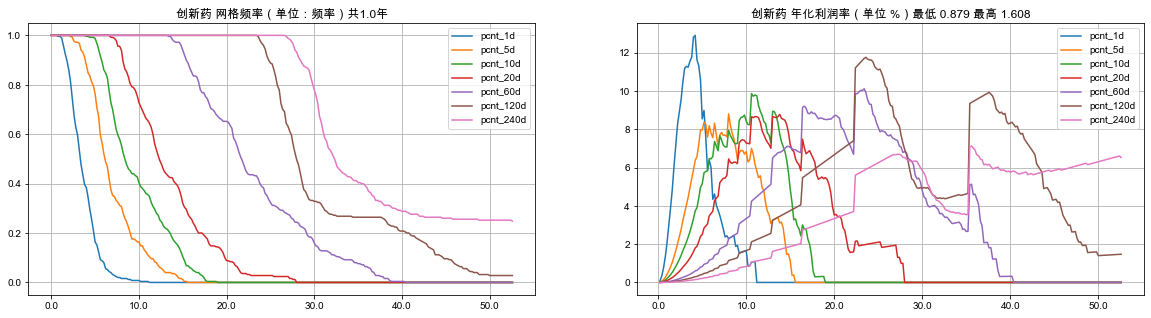

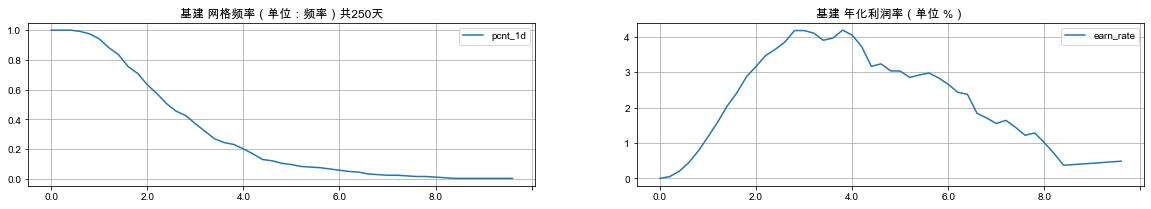

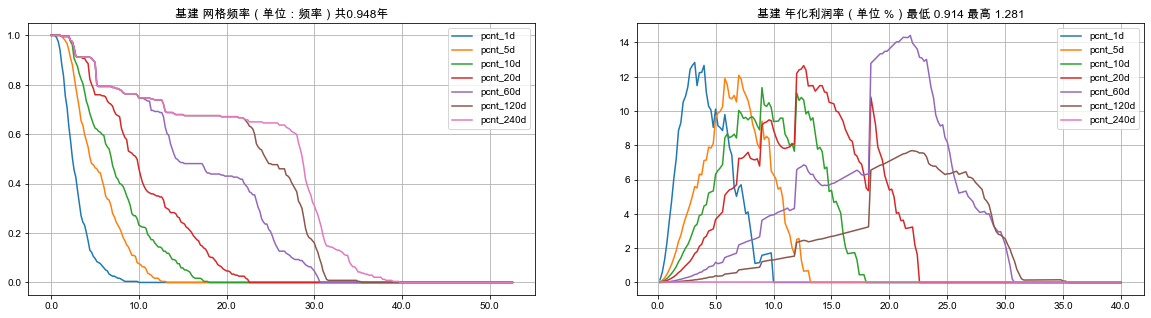

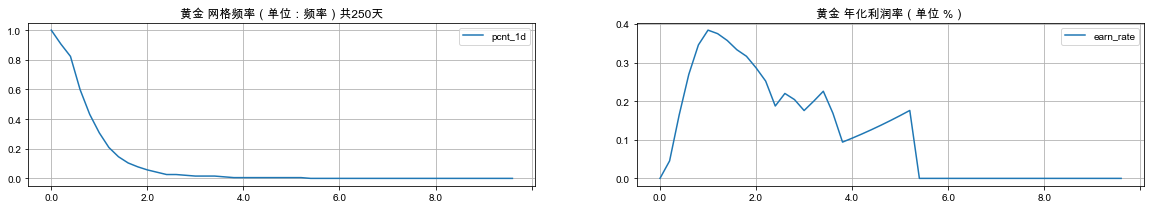

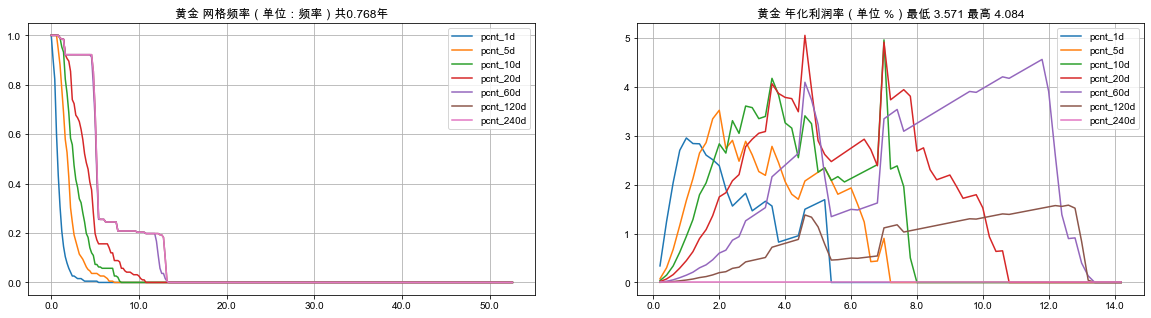

In [5]:
#等市值网格收益计算

stock = pd.read_csv('./stock.csv')
days = 250
for row in stock.itertuples():
    compute_net_basic('./' + row[2] + '.csv', row[3], days)
    compute_net_basic_long('./' + row[2] + '.csv', row[3], days)

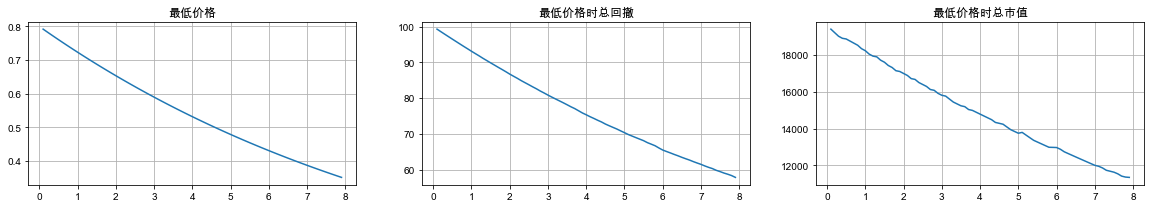

In [15]:
compute_constant_net_risk(10000, 10000, 0.8, buy_money=1000)